In [32]:
import os
import tarfile
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
     os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()
  
def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)



fetch_housing_data()
housing = load_housing_data()

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [33]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [34]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f00384c88>,
      dtype=object)

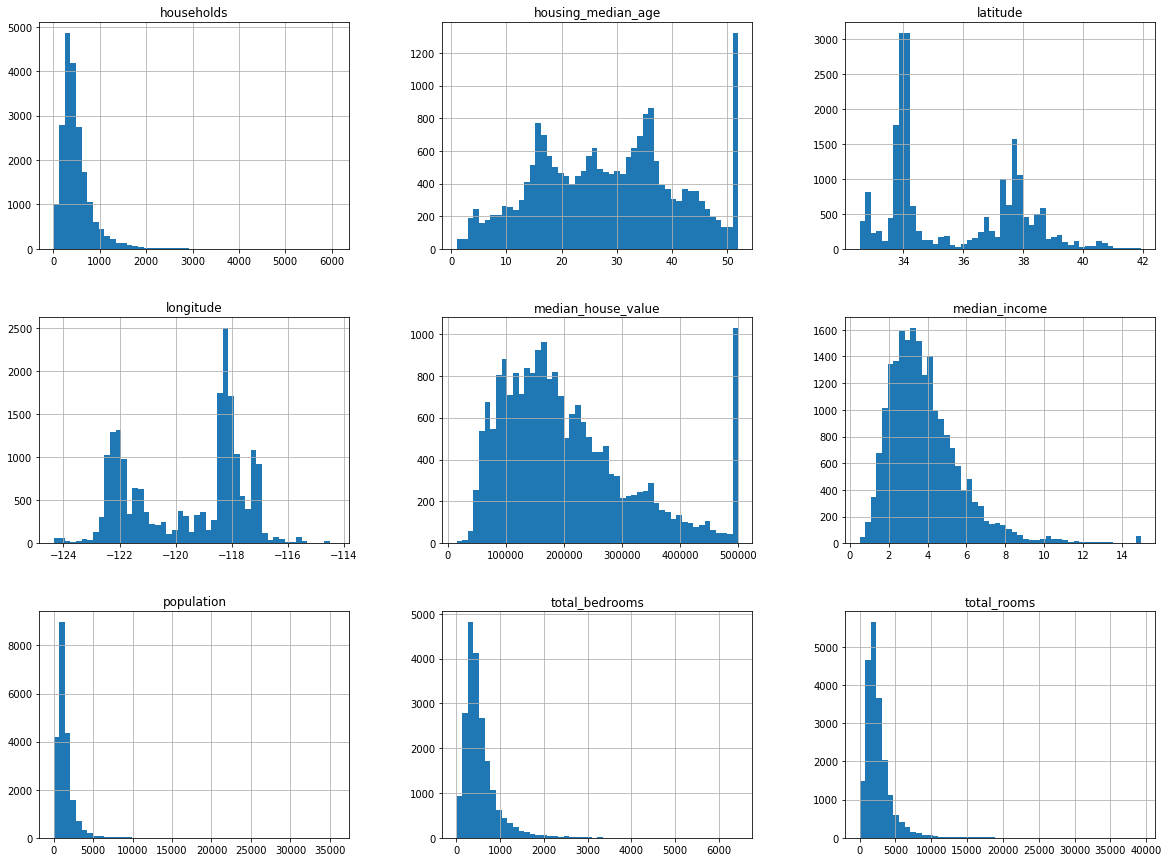

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize = (20, 15))

In [0]:


def split_train_test(data, test_ratio):
  suffle_indices = np.random.permutation(len(data))
  np.random.seed(42)
  test_set_size = int(len(data) * test_ratio)
  test_indices = suffle_indices[:test_set_size] 
  train_indices = suffle_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]



In [0]:
#train_data, test_data = split_train_test(housing, 0.2)
#train_data.head()

In [0]:
#train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)#izipizi

In [37]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


In [0]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [0]:
for set in (strat_train_set, strat_test_set):
  set.drop(["income_cat"], axis=1, inplace=True)

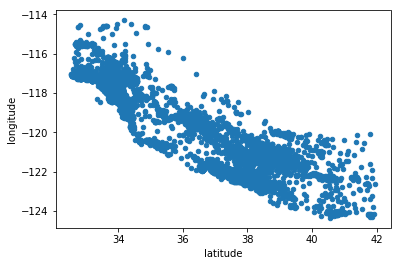

In [40]:
housing = strat_train_set.copy()
housing.plot(kind = 'scatter', x= "latitude", y = "longitude")

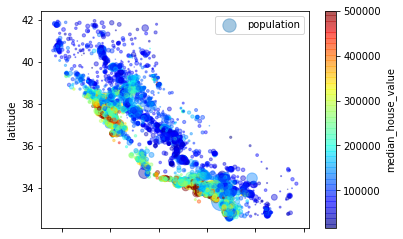

In [9]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population",
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [41]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [42]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/ housing['households']
housing['rooms_per_population']= housing['total_rooms']/housing['population']

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)





median_house_value          1.000000
median_income               0.687160
rooms_per_population        0.199429
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [0]:
#Preprocessing


housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [0]:
#imputer = SimpleImputer(strategy="median")


In [0]:

housing_num = housing.drop("ocean_proximity", axis=1)
#imputer.fit(housing_num)

In [0]:
#SKL Inspection
#imputer.strategy
#imputer.statistics_



In [0]:

#X = imputer.transform(housing_num)#numpyarray

#housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [17]:
housing_cat = housing["ocean_proximity"].copy()
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot


array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [18]:
housing_num.values


array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

In [47]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return X[self.attribute_names].values
  
  
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self # nothing else to do
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    rooms_per_population = X[:, rooms_ix] / X[:, population_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household,
      bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, X, y=0):
        self.encoder.fit(X)
        return self
    def transform(self, X, y=0):
        return self.encoder.transform(X)


num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
  ('selector', DataFrameSelector(num_attribs)),
  ('imputer', SimpleImputer(strategy="median")),
  ('std_scaler', StandardScaler()),
  ])
cat_pipeline = Pipeline([
  ('selector', DataFrameSelector(cat_attribs)),
  ('label_binarizer', MyLabelBinarizer()),
  ])
full_pipeline = FeatureUnion(transformer_list=[
  ("num_pipeline", num_pipeline),
  ("cat_pipeline", cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared[1]

array([-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
       -0.99833135, -1.02222705,  1.33645936,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [48]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [171]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

69050.98178244587

In [0]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                         scoring='neg_mean_squared_error', cv= 10)
rmse_scores = np.sqrt(-scores)

In [173]:
def display_scores(scores):
    print("Score:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(rmse_scores)

Score: [67450.42057782 67329.50264436 68361.84864912 74639.88837894
 68314.56738182 71628.61410355 65361.14176205 68571.62738037
 72476.18028894 68098.06828865]
Mean: 69223.18594556303
Standard deviation: 2657.268311277696


In [174]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring = 'neg_mean_squared_error', cv=10)
forest_rmse = np.sqrt(-scores)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [175]:

display_scores(forest_rmse)

Score: [51076.44016868 49510.4807201  51728.4112535  51658.86250416
 51319.07292263 55436.48558586 52015.92285441 52270.94656242
 53965.1582806  51562.08563126]
Mean: 52054.386648361935
Standard deviation: 1536.6067055615426


In [176]:
joblib.dump(forest_reg, "forest_reg.pkl")

['forest_reg.pkl']

In [0]:
#Fine-Tuning
param_grid= [
             {'n_estimators':[35, 40, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features': [2, 3, 4]},
            ]

In [153]:
grid_search= GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
    

In [178]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 40}

In [179]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

52638.798405343274 {'max_features': 2, 'n_estimators': 35}
52854.66279165916 {'max_features': 2, 'n_estimators': 40}
52879.226763261926 {'max_features': 2, 'n_estimators': 30}
50739.298162153624 {'max_features': 4, 'n_estimators': 35}
50855.52755997398 {'max_features': 4, 'n_estimators': 40}
50826.59541293336 {'max_features': 4, 'n_estimators': 30}
50124.977492733946 {'max_features': 6, 'n_estimators': 35}
50269.28217290962 {'max_features': 6, 'n_estimators': 40}
50257.60274569777 {'max_features': 6, 'n_estimators': 30}
50157.10493521962 {'max_features': 8, 'n_estimators': 35}
49887.09791686007 {'max_features': 8, 'n_estimators': 40}
50353.90347743926 {'max_features': 8, 'n_estimators': 30}
61562.606461459996 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54200.651204154274 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60899.739994046315 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53417.52837880825 {'bootstrap': False, 'max_features': 3, 'n_esti

In [180]:
#Analyze the Best Models and Their Errors
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances


array([1.12394538e-01, 1.00656555e-01, 5.01602893e-02, 2.92909669e-02,
       2.55540173e-02, 3.60252148e-02, 2.49889466e-02, 4.48202711e-01,
       1.11852608e-02, 1.53685377e-01, 4.03286299e-05, 2.13545655e-03,
       5.68033760e-03])

In [195]:
extra_attribs = ["rooms_per_pop","rooms_per_household", "pop_per_household", "bedrooms_per_room" ]
cat_one_hot_attribs = list(encoder.classes_)
attribs = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attribs))


[(4.0328629948348636e-05, 'pop_per_household'),
 (0.0021354565502516173, 'bedrooms_per_room'),
 (0.005680337596561827, '<1H OCEAN'),
 (0.011185260813495437, 'rooms_per_pop'),
 (0.024988946612309677, 'households'),
 (0.025554017332914847, 'total_bedrooms'),
 (0.02929096685156872, 'total_rooms'),
 (0.03602521475134728, 'population'),
 (0.050160289307794405, 'housing_median_age'),
 (0.100656555426471, 'latitude'),
 (0.1123945382045964, 'longitude'),
 (0.15368537664576123, 'rooms_per_household'),
 (0.44820271127697925, 'median_income')]

In [49]:
supportVectorMachine = SVR()
supportVectorMachine.fit(housing_prepared, housing_labels)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [69]:
param_grid = [{'C':[150.0,190.0,110.0], 'kernel':['linear']}]
grid_search = GridSearchCV(supportVectorMachine, param_grid, cv= 5,
                          scoring = 'neg_mean_squared_error')
grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [150.0, 190.0, 110.0], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [70]:
grid_search.best_params_

{'C': 190.0, 'kernel': 'linear'}

In [71]:
#Evaluate on Test Set
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

69321.6290050771
